# Event Detection

We expect that as something happens, individuals will tweet about it in real-time causing bursts in Twitter activity. In 2011 Twitter [blogged](https://blog.twitter.com/2011/global-pulse) about how their site's avtivity was a reflection of global pulse, citing when volume spiked over 5,000 tweets per second following an earthquake.

Within our event timeline, we can identify specific times that importance for summarization in this way. We can call these subevents.

Using theory related to anomaly detection in signal processing for time series data, we can identify patterns that may significantly deviate from an underlying distribution in the dataset. By computing an expected frequency of occurrences per time window we can measure differences in behavior above or below this level for an interval, which may indicate an event activity. Furthermore, by calculating this expected frequency using a historical moving average, this approach can easily be applied to online data.

Related Twitter-Specific Frameworks
- [Twitter's Breakout Detection](https://blog.twitter.com/2014/breakout-detection-in-the-wild)
- [Twitter's Anomoly Detection](https://blog.twitter.com/2015/introducing-practical-and-robust-anomaly-detection-in-a-time-series)

**Measurment:** We define our measure as volume of tweets per minute, and an anomoly in this frequency would indicate a subevent.

**Method:** Anomalies are then detected by measuring the deviation from an expected frequency. Expected frequency is calculated using simple moving average using a window of 5 minutes, otherwise known as rolling mean. The intensity of the subevent is then measured as the deviation from the expected, and can be used to set a dynamic threshold for summarizing those which are most significant.

$expected = \frac{1}{n} \sum_{i=0}^{n-1} y-i$

Simple outlier detection algorithms look at values greated than a number of standard deviations from mean. Since we are limited to summarizing only that data which we can communicate we set a fixed threshold.

Subevents are considered for summarization if $y_{i} - expected > threshold$ where *threshold* is dynamically computed to include top *k* number of subevents.

### Input
- event tweets

### Output
- for every event minute
    - the volume of tweets
    - subevent rank, measured as deviation in descending order

#### import tools

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')
import re

#### import data

In [2]:
event_name = input('Enter Event Name: ')
event_filename = re.sub("\W+", "", event_name.strip())

Enter Event Name: Monaco Grand Prix


In [3]:
df = pd.read_csv('data/final/event_%s_data.txt' % event_filename, sep='\t', encoding='utf-8', header=0, parse_dates=['created_at'], dtype={'twitter_id' : 'str'})
df.shape

(64483, 35)

#### twitter_id as index

In [4]:
df.set_index('twitter_id', inplace=True)

## Rolling Mean

In [66]:
d = df.reset_index().set_index('created_at').groupby([pd.TimeGrouper(freq='T')])['twitter_id'].agg(['count'])
timeframe = pd.date_range(d.index.min(), d.index.max(), freq='T')
d = d.reindex(timeframe, fill_value=0)

In [67]:
d['mean'] = d['count'].rolling(window=5).agg(['mean'])
d['std'] = d['count'].rolling(window=5).agg(['std'])

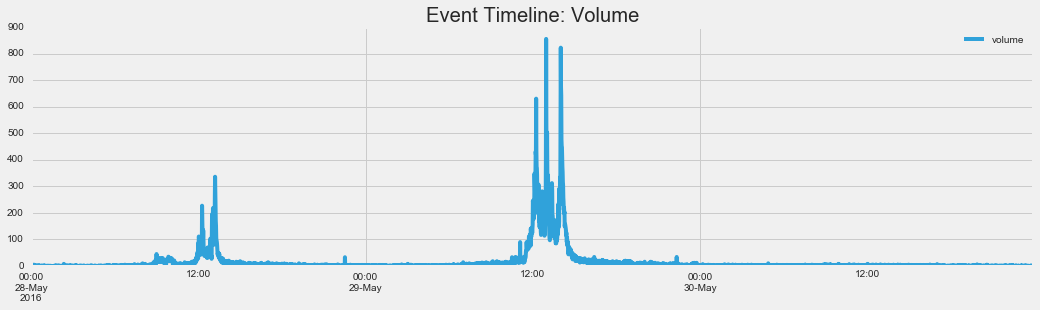

In [58]:
plt.title('Event Timeline: Volume')
ax = d['count'].plot(figsize=(16,4), label='volume')
plt.legend(loc='best')
plt.show()

#### zoom in at max event volume

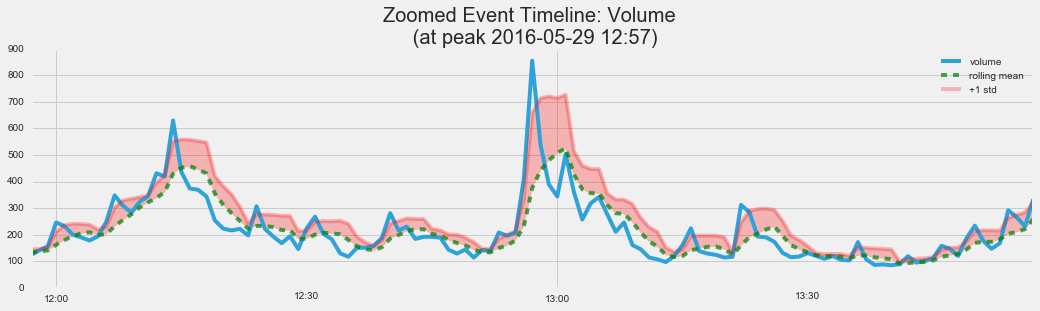

In [8]:
idxmax = d['count'].idxmax()
zoommin = idxmax - pd.DateOffset(hours=1)
zoommax = idxmax + pd.DateOffset(hours=1)

plt.title('Zoomed Event Timeline: Volume \n (at peak %s)' % str(idxmax)[:16])
ax = d[zoommin:zoommax]['count'].plot(figsize=(16,4), label='volume')
d[zoommin:zoommax]['mean'].plot(ax=ax, style='g--', alpha=.70, label='rolling mean')
(d[zoommin:zoommax]['mean'] + d[zoommin:zoommax]['std']).plot(ax=ax, color='r', alpha=.25, label='+1 std')
ax.fill_between(d.index, d['mean'], d['mean'] + d['std'], alpha=.25, color='r')
plt.legend(loc='best')
plt.show()

## Rolling Mean Deviation

#### mark subevent if outside bounds of +1 standard deviation from rolling mean

In [68]:
d['deviation'] = d['count'] - d['mean']

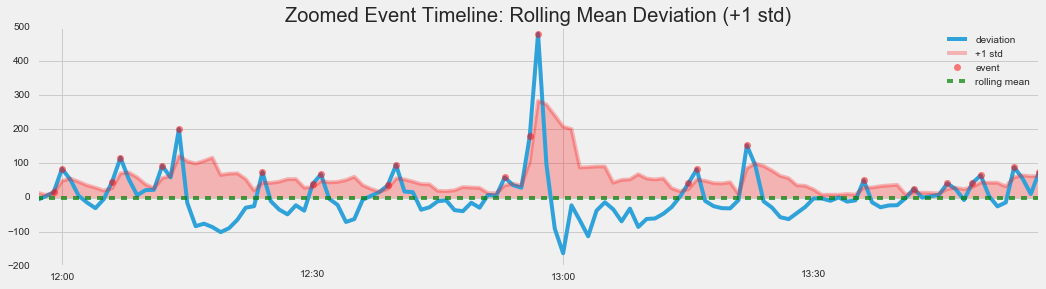

In [10]:
plt.title('Zoomed Event Timeline: Rolling Mean Deviation (+1 std)')
ax = d[zoommin:zoommax]['deviation'].plot(figsize=(16,4), label='deviation')
d[zoommin:zoommax]['std'].plot(ax=ax, color='r', alpha=.25, label='+1 std')
d[d['count'] > (d['mean'] + d['std'])][zoommin:zoommax]['deviation'].plot(ax=ax, style='ro', alpha=.50, label='event')
ax.axhline(y=0, linestyle='--', c='g', alpha=.70, label='rolling mean')
ax.fill_between(d.index, 0, 0 + d['std'], alpha=.25, color='r')
plt.legend(loc='best')
plt.show()

In [11]:
print('Total SubEvents:', d[d['count'] > (d['mean'] + d['std'])].shape[0])

Total SubEvents: 735


#### use top k deviations from rolling mean

In [12]:
k = 10
threshold = d[d['deviation']>0]['deviation'].sort_values(ascending=False).iloc[:k].min()

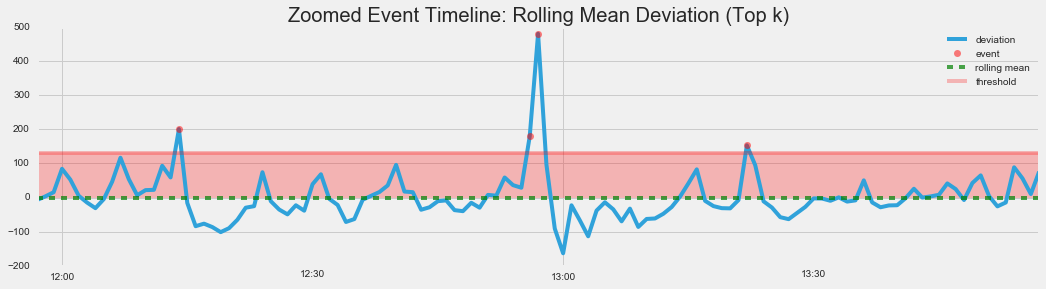

In [13]:
plt.title('Zoomed Event Timeline: Rolling Mean Deviation (Top k)')
ax = d[zoommin:zoommax]['deviation'].plot(figsize=(16,4), label='deviation')
d[d['deviation'] > threshold][zoommin:zoommax]['deviation'].plot(ax=ax, style='ro', alpha=.50, label='event')
ax.axhline(y=0, linestyle='--', c='g', alpha=.70, label='rolling mean')
ax.axhline(y=threshold, linestyle='-', color='r', alpha=.25, label='threshold')
ax.fill_between(d.index, 0, threshold, alpha=.25, color='r')
plt.legend(loc='best')
plt.show()

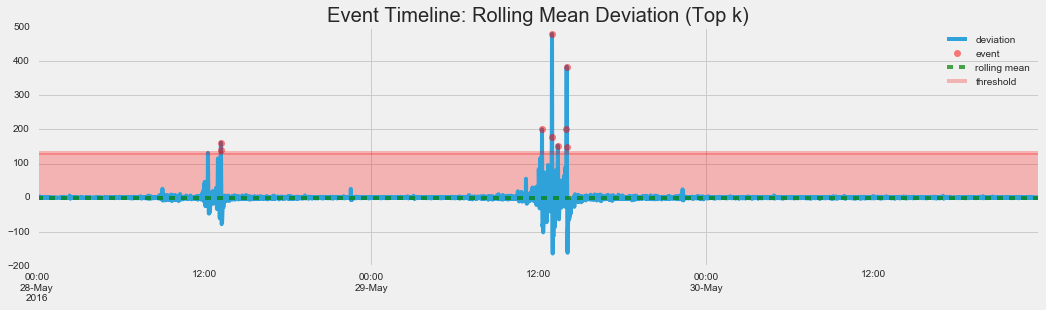

In [14]:
plt.title('Event Timeline: Rolling Mean Deviation (Top k)')
ax = d['deviation'].plot(figsize=(16,4), label='deviation')
d[d['deviation'] > threshold]['deviation'].plot(ax=ax, style='ro', alpha=.50, label='event')
ax.axhline(y=0, linestyle='--', c='g', alpha=.70, label='rolling mean')
ax.axhline(y=threshold, linestyle='-', color='r', alpha=.25, label='threshold')
ax.fill_between(d.index, 0, threshold, alpha=.25, color='r')
plt.legend(loc='best')
plt.show()

#### use large top k threshold for dynamic event slicing

In [15]:
viz_k = 100
threshold_viz = d[d['deviation']>0]['deviation'].sort_values(ascending=False).iloc[:viz_k].min()
viz_start = d[d['deviation'] > threshold_viz].index.min()
viz_end = d[d['deviation'] > threshold_viz].index.max()

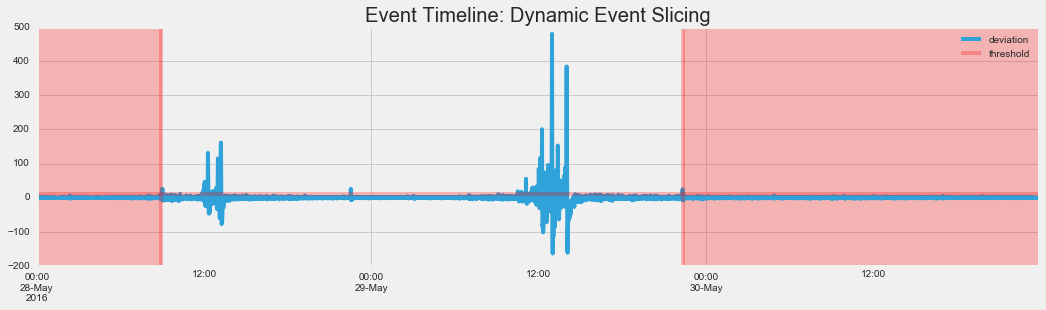

In [16]:
plt.title('Event Timeline: Dynamic Event Slicing')
ax = d['deviation'].plot(figsize=(16,4), label='deviation')
ax.axhline(y=threshold_viz, linestyle='-', c='r', alpha=.25, label='threshold')
ax.axvline(x=viz_start, linestyle='-', c='r', alpha=.25)
ax.axvline(x=viz_end, linestyle='-', c='r', alpha=.25)
ax.axvspan(0, viz_start, alpha=0.25, color='red')
ax.axvspan(viz_end, d.index.max(), alpha=0.25, color='red')
plt.legend(loc='best')
plt.show()

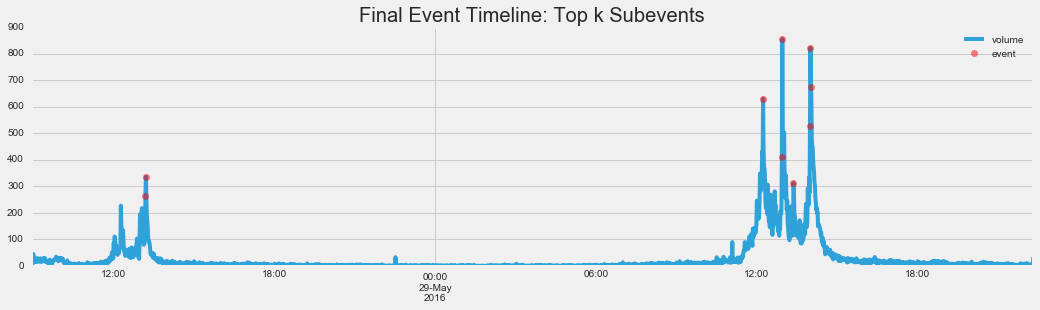

In [17]:
plt.title('Final Event Timeline: Top k Subevents')
ax = d[viz_start:viz_end]['count'].plot(figsize=(16,4), label='volume')
d[d['deviation'] > threshold]['count'].plot(ax=ax, style='ro', alpha=.50, label='event')
plt.legend(loc='best')
plt.show()

## Get Deviation Rank
- measure of subevent importance
- slice event
- export data

In [69]:
d['rank'] = d['deviation'].rank(axis=0, ascending=False)

In [70]:
d.sort_values(by='deviation', ascending=False).head()

,count,mean,std,deviation,rank
2016-05-29 12:57:00,855,375.4,282.776060,479.6,1.0
2016-05-29 14:00:00,822,438.0,242.791062,384.0,2.0
2016-05-29 13:59:00,528,326.8,118.417482,201.2,3.0
2016-05-29 12:14:00,630,429.6,121.195297,200.4,4.0
2016-05-29 12:56:00,411,232.2,103.907170,178.8,5.0


In [72]:
d.to_csv('data/final/event_%s_subevents.txt' % event_filename, sep='\t', encoding='utf-8', header=True, index=True)

## Apply to All Events

#### add subevent info to data

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
import string

In [ ]:
#make sure to handle text as string
#df['text'] = df['text'].astype('str')
#remove links
#df['text_clean'] = df['text'].apply(lambda text: ' '.join([(w[:w.find('http')] if 'http' in w else w) for w in text.split()]))
#remove hashtag symbol
#df['text_clean'] = df['text_clean'].apply(lambda text: text.replace('#', ''))
#remove mention symbol
#df['text_clean'] = df['text_clean'].apply(lambda text: text.replace('@', ''))
#initiate, apply tokenization
#tknzr = nltk.TweetTokenizer()
#df['text_clean'] = df['text_clean'].apply(lambda s: ' '.join([w.lower() for w in tknzr.tokenize(str(s))]))

In [21]:
%%time
df['stdz_frequency_1min'] = np.nan
df['stdz_rollmean_frequency_win5min'] = np.nan
df['stdz_rollmean_frequency_deviation'] = np.nan

for event_df in allevents:

    event_dist = event_df.set_index('created_at').groupby([pd.TimeGrouper(freq='min')])['twitter_id'].agg(['count'])
    timeframe = pd.date_range(event_dist.index.min(), event_dist.index.max(), freq='T')
    event_dist = event_dist.reindex(timeframe, fill_value=0)
    
    event_dist['mean'] = event_dist['count'].rolling(window=5).agg(['mean'])
    event_dist['deviation'] = event_dist['count'] - event_dist['mean']    

    event_temp = event_df[['twitter_id', 'created_at']]
    event_temp['created_at'] = event_temp['created_at'].apply(lambda x: x.replace(second=0))
    event_temp.set_index(['created_at'], inplace=True)

    #join subevent data on minute of created_at
    event_dist = pd.merge(event_temp, event_dist[['count', 'mean', 'deviation']], how='left', left_index=True, right_index=True)
    
    event_dist.set_index('twitter_id', inplace=True)
    
    #normalize
    event_dist['count'] = event_dist['count'] / event_dist['count'].max()
    event_dist['mean'] = event_dist['mean'] / event_dist['mean'].max()
    event_dist['deviation'] = event_dist['deviation'].apply(lambda x: [0,x][x > 0])
    event_dist['deviation'] = event_dist['deviation'] / event_dist['deviation'].max()
    
    #rename
    event_dist.columns = ['stdz_frequency_1min', 'stdz_rollmean_frequency_win5min', 'stdz_rollmean_frequency_deviation']
    
    df.update(event_dist)

Wall time: 3.44 s


c:\miniconda3\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Summarize

#### add subevent summary info to data

In [74]:
%%time
df['stdz_1min_tfidf'] = np.nan
df['1min_meanco'] = np.nan

i = 1
for event in df['event'].unique():
    print('event:', i)
    event_df = df[df['event'] == event]
    
    event_df['created_at'] = event_df['created_at'].apply(lambda d: d.replace(second=0))
    
    subevent_times = event_df.groupby('created_at')['stdz_rollmean_frequency_deviation'].agg(['mean']).sort_values(by='mean', ascending=False)
    
    subi = 1
    for t in subevent_times.index[:10]: 
    
        subevent_df = event_df[event_df['created_at'] == t]
        subevent_df.reset_index(inplace=True)
    
        countvectorizer = CountVectorizer()
        X = countvectorizer.fit_transform(subevent_df['text_clean'])
        Xco = X * X.T
        meanco = Xco.todense().mean(axis=1)
        
        meanco = pd.DataFrame(meanco, columns=['1min_meanco'])
        
        tfidfvectorizer = TfidfVectorizer(max_df=.9, min_df=.1, stop_words='english')
        X = tfidfvectorizer.fit_transform(subevent_df['text_clean'])
        tfidf = X.sum(axis=1)
        
        tfidf = pd.DataFrame(tfidf, columns=['stdz_1min_tfidf'])
    
        scores = pd.concat([meanco, tfidf], axis=1)
    
        #merge tfidf info with subevent
        subevent_df.update(scores)
        
        #set index back
        subevent_df.set_index('twitter_id', inplace=True)
        
        #normalize
        subevent_df['stdz_1min_tfidf'] = subevent_df['stdz_1min_tfidf'] / subevent_df['stdz_1min_tfidf'].max()
        
        event_df.update(subevent_df)
        print('subevent', subi)
        subi = subi+1
        
    df.update(event_df[['stdz_1min_tfidf', '1min_meanco']])
    print('finished event:', i)
    i = i+1

c:\miniconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\miniconda3\lib\site-packages\pandas\core\frame.py:3757: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  raise_on_error=True)


event: 1
subevent 1
subevent 2
subevent 3
subevent 4
subevent 5
subevent 6
subevent 7
subevent 8
subevent 9
subevent 10
finished event: 1
event: 2
subevent 1
subevent 2
subevent 3
subevent 4
subevent 5
subevent 6
subevent 7
subevent 8
subevent 9
subevent 10
finished event: 2
event: 3
subevent 1
subevent 2
subevent 3
subevent 4
subevent 5
subevent 6
subevent 7
subevent 8
subevent 9
subevent 10
finished event: 3
event: 4
subevent 1
subevent 2
subevent 3
subevent 4
subevent 5
subevent 6
subevent 7
subevent 8
subevent 9
subevent 10
finished event: 4
event: 5
subevent 1
subevent 2
subevent 3
subevent 4
subevent 5
subevent 6
subevent 7
subevent 8
subevent 9
subevent 10
finished event: 5
Wall time: 1min 43s


c:\miniconda3\lib\site-packages\ipykernel\__main__.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Print Summaries

In [62]:
k_subevents = 10

#### using term overlap

In [81]:
for event in df['event'].unique():
    
    print()
    print(event)
    print()

    event_df = df[df['event'] == event]
    
    event_df['created_at'] = event_df['created_at'].apply(lambda d: d.replace(second=0))
    
    subevents = event_df.sort_values(by=['stdz_rollmean_frequency_deviation', '1min_meanco'], ascending=False).groupby('stdz_rollmean_frequency_deviation', sort=False).first().iloc[0:k_subevents]
    
    subevents.sort_values(by='created_at', ascending=True, inplace=True)
    
    for deviation,tweet in subevents.iterrows():
    
        print(tweet['created_at'], tweet['text'])


EgyptAir Flight 804

2016-05-19 04:50:00 An EgyptAir flight from Paris to Cairo with 69 people on board disappeared from radar over Egyptian airspace #EgyptAir
2016-05-19 05:58:00 Who cares about the nationalities of the passengers. The issue is that those people are in danger. They're in my thoughts :( #EgyptAir
2016-05-19 07:51:00 #EgyptAir: @EGYPTAIR - Flight MS804 From Paris To Cairo Disappears.: EgyptAir flight MS804 heading from Paris... https://t.co/uS6FvD01yG
2016-05-19 11:18:00 EgyptAir Flight 804 Disappears En Route From Paris To Cairo With 66 On Board https://t.co/wuOMP6uSCl #Infowars #EgyptAir #Flight804
2016-05-19 11:54:00 Buy Followers -&gt; 1000 Twitter followers 10$ #EgyptAir #NationalSendANudeDay #MySummerPlans  https://t.co/sE5XUwo5gl
2016-05-19 12:25:00 Buy Followers -&gt; 1000 Twitter followers 10$ #EgyptAir #NationalSendANudeDay #MySummerPlans  https://t.co/o3dzPjVNz1
2016-05-19 13:38:00 Buy Followers -&gt; 1000 Twitter followers 10$ #EgyptAir #MarcoPannella #Feli

c:\miniconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### using tfidf scores

In [80]:
for event in df['event'].unique():
    
    print()
    print(event)
    print()

    event_df = df[df['event'] == event]
    
    event_df['created_at'] = event_df['created_at'].apply(lambda d: d.replace(second=0))
    
    subevents = event_df.sort_values(by=['stdz_rollmean_frequency_deviation', 'stdz_1min_tfidf'], ascending=False).groupby('stdz_rollmean_frequency_deviation', sort=False).first().iloc[0:k_subevents]
    
    subevents.sort_values(by='created_at', ascending=True, inplace=True)
    
    for deviation,tweet in subevents.iterrows():
    
        print(tweet['created_at'], tweet['text'])


EgyptAir Flight 804

2016-05-19 04:50:00 Reuters cites a French airport official saying of flight #MS804:  "It did not land, that is all we can say for the moment." #EgyptAir
2016-05-19 05:58:00 saying a prayer for all 66 lives on that #EgyptAir flight. despite my last tweet, i genuinely hate seeing shit like this &amp; they are wrong.
2016-05-19 07:51:00 Is it just an accident that 2 planes falls belong to the most 2 serious country fighting terrorism #Russia #Egypt #EgyptAir
2016-05-19 11:05:00 #EgyptAir We're assured that the Med is patrolled by EU naval boats to prevent people trafficking?Why only 8 merchant vessels at crash site
2016-05-19 11:18:00 my heart &amp; prayers go out to the crew and passengers of the #EgyptAir flight, as well as those who lost loved ones.. i couldn't even imagine
2016-05-19 11:54:00 #EgyptAir: Missing flight 804 from Paris to Cairo made 'Sudden Swerves' Before crash, officials Say. How Awful!!! This is why I hate flying.
2016-05-19 12:25:00 #EgyptAir I

c:\miniconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
